The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


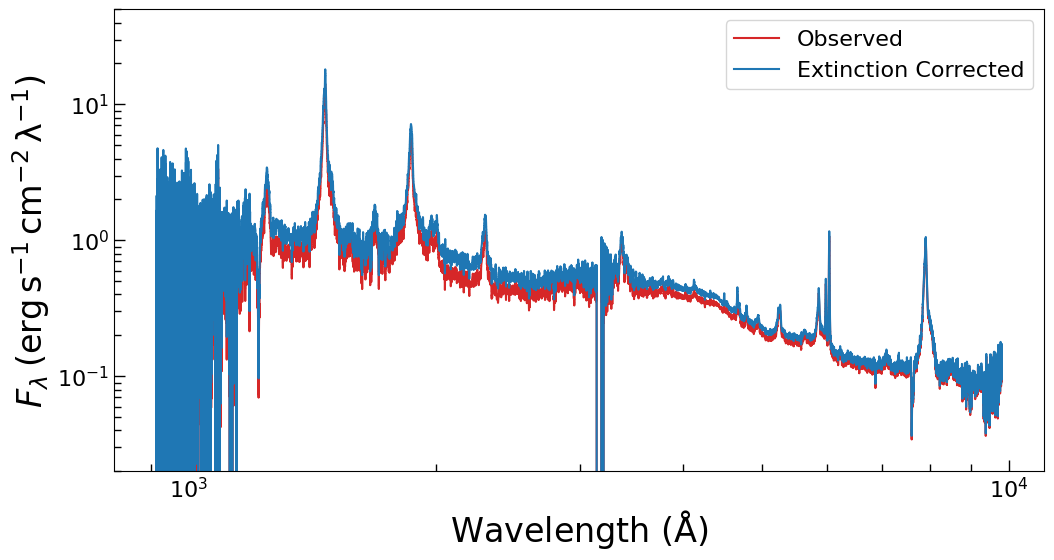

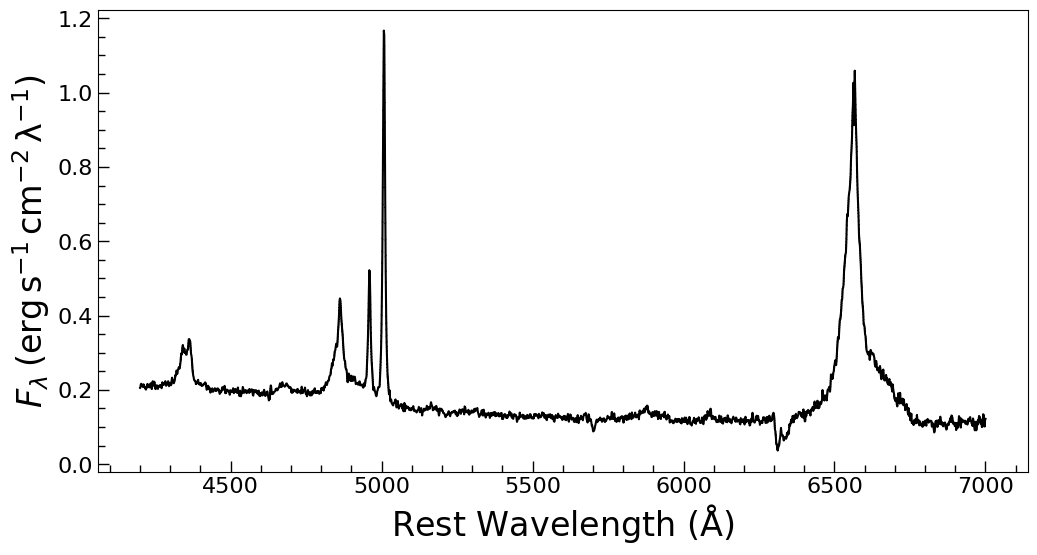

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

from astropy.modeling import models, fitting
import sys
sys.path.append("../..")
import sagan

import matplotlib as mpl
mpl.rc("xtick", direction="in", labelsize=16)
mpl.rc("ytick", direction="in", labelsize=16)
mpl.rc("xtick.major", width=1., size=8)
mpl.rc("ytick.major", width=1., size=8)
mpl.rc("xtick.minor", width=1., size=5)
mpl.rc("ytick.minor", width=1., size=5)

# automatic reload the modules
%load_ext autoreload
%autoreload 2

ls_km = 2.99792e5 # km/s
datapath = 'data'
hdul = fits.open('4cp34sed.fit')#---------------------------修改文件名
header = hdul[0].header
flux = hdul[0].data * 1e14

w0 = header['CRVAL1']
dw = header['CD1_1']
wave = w0 + dw*np.arange(flux.size)

# Find the V band attenuation from https://ned.ipac.caltech.edu/ -- FOREGROUND GALACTIC EXTINCTION
from extinction import ccm89, remove

A_V = 0.101    #------------------------------修改 消光系数
flux_dred = remove(ccm89(wave, A_V, r_v=3.1, unit='aa'), flux)

fig, ax = plt.subplots(figsize=(12, 6))
ax.step(wave, flux, label='Observed', c='C3')
ax.step(wave, flux_dred, label='Extinction Corrected', c='C0')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'Wavelength ($\mathrm{\AA}$)', fontsize=24)
ax.set_ylabel(r'$F_\lambda\:(\mathrm{erg\,s^{-1}\,cm^{-2}\,\lambda^{-1}})$', fontsize=24)
ax.legend(fontsize=16)
ax.set_ylim(0.02, 50)#-------------------------------修改y可见范围
ax.minorticks_on()
plt.show()
zred = 0.2055 #-------------------------------------修改红移

fig, ax = plt.subplots(figsize=(12, 6))
wmin, wmax = 4200, 7000
wave_rst = wave / (1 + zred)
fltr = (wave_rst > wmin) & (wave_rst < wmax)
wave_use = wave_rst[fltr]
flux_use = flux_dred[fltr]

ax.step(wave_use, flux_use, color='k')
ax.set_xlabel(r'Rest Wavelength ($\mathrm{\AA}$)', fontsize=24)
ax.set_ylabel(r'$F_\lambda\:(\mathrm{erg\,s^{-1}\,cm^{-2}\,\lambda^{-1}})$', fontsize=24)
ax.minorticks_on()
plt.show()

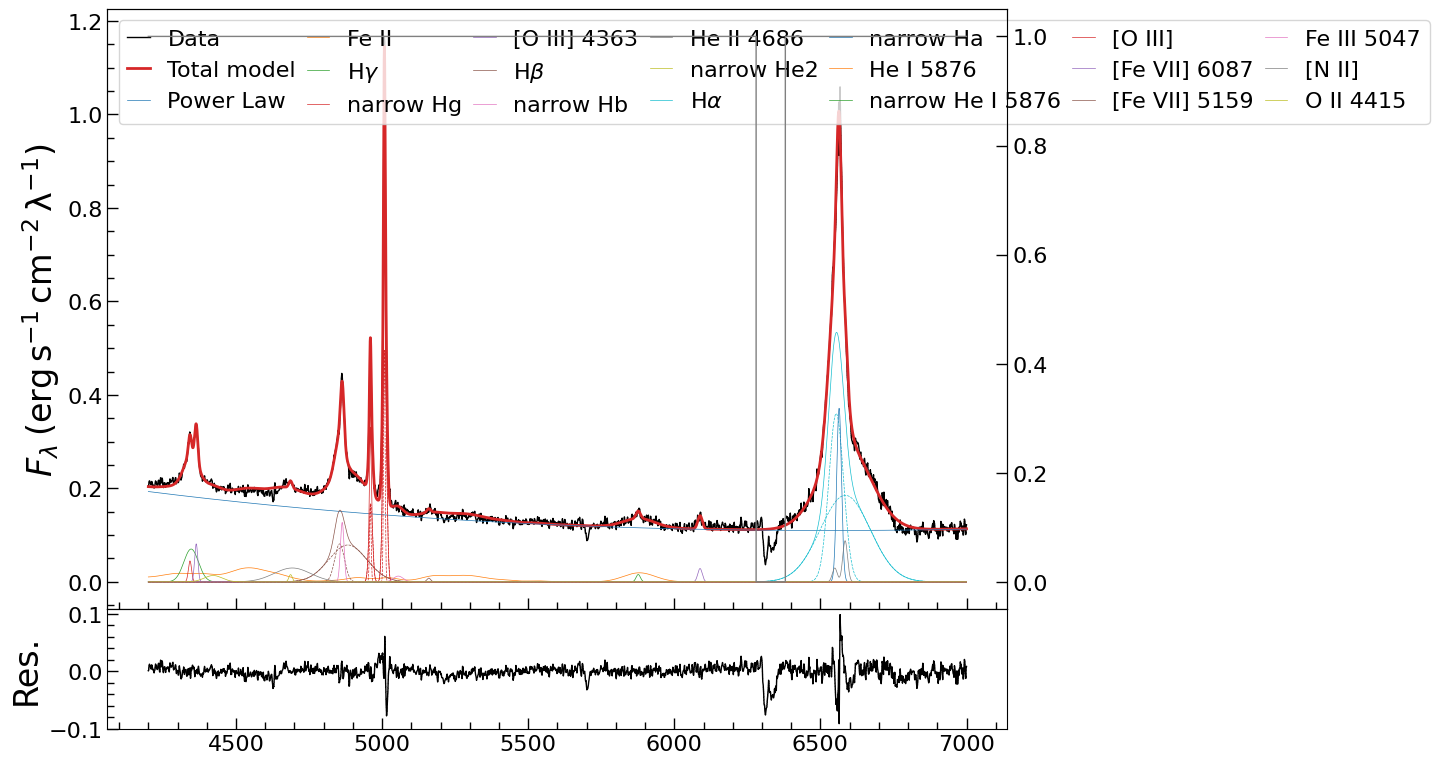

<PowerLaw1D(amplitude=0.07344631, x_0=6200., alpha=0.34242981, name='Power Law')>
<IronTemplate(amplitude=0.0214342, stddev=2499.157, z=0., name='Fe II')>
<Line_MultiGauss(amp_c=0.03198445, dv_c=339.41820051, sigma_c=1730.12317541, wavec=4341.785, name='H$\\gamma$')>
<Line_Gaussian(amplitude=0.02037772, dv=49.71687898, sigma=377.5613403, wavec=4341.785, name='narrow Hg')>
<Line_Gaussian(amplitude=0.03721868, dv=49.71687898, sigma=377.5613403, wavec=4363.21, name='[O III] 4363')>
<Line_MultiGauss(amp_c=0.0430214, dv_c=-500., sigma_c=1018.5306625, wavec=4862.721, amp_w0=0.97902092, dv_w0=1804.47819708, sigma_w0=4000., name='H$\\beta$')>
<Line_Gaussian(amplitude=0.06756192, dv=49.71687898, sigma=377.5613403, wavec=4862.721, name='narrow Hb')>
<Line_MultiGauss(amp_c=0.01503466, dv_c=500., sigma_c=4000., wavec=4686., name='He II 4686')>
<Line_Gaussian(amplitude=0.00784111, dv=49.71687898, sigma=377.5613403, wavec=4686., name='narrow He2')>
<Line_MultiGauss(amp_c=0.23602722, dv_c=-403.594622

In [40]:
poly = models.Polynomial1D(degree=2, name='multi')  # The name must be `multi`; no more than 5th order
wave_dict = sagan.utils.line_wave_dict
label_dict = sagan.utils.line_label_dict

pl = models.PowerLaw1D(amplitude=0.07344631, x_0=6200, alpha=0.34242981, fixed={'x_0': True,'amplitude':True,'alpha':True},name='Power Law')
iron = sagan.IronTemplate(amplitude=0.0214342, stddev=2499.157, z=0, name='Fe II',fixed={'amplitude':True,'stddev':True})
bounds = {'sigma_w0': (100, 4000),'sigma_c': (100, 4000), 'dv_c': (-500, 500)}

b_ha = sagan.Line_MultiGauss(n_components=2, amp_c=0.23, dv_c=-406, sigma_c=1160, 
                             wavec=wave_dict['Halpha'], name=label_dict['Halpha'],
                             amp_w0=0.5159, dv_w0=1407, sigma_w0=3900)

b_hb = sagan.Line_MultiGauss(n_components=2, amp_c=0.04, dv_c=-500, sigma_c=1020, 
                             wavec=wave_dict['Hbeta'], name=label_dict['Hbeta'],
                             amp_w0=0.9786, dv_w0=1783, sigma_w0=4000, bounds=bounds)
#b_hb = sagan.Line_MultiGauss(n_components=1, amp_c=0.13, dv_c=-280, sigma_c=1400, 
#                             wavec=wave_dict['Hbeta'], name=label_dict['Hbeta'])

#b_hg = sagan.Line_MultiGauss(n_components=2, amp_c=0.05, dv_c=400, sigma_c=1480, 
#                             wavec=wave_dict['Hgamma'], name=label_dict['Hgamma'],
#                             amp_w0=0.1, dv_w0=350, sigma_w0=3500,bounds=bounds)
b_hg = sagan.Line_MultiGauss(n_components=1, amp_c=0.02519, dv_c=607, sigma_c=2388, 
                             wavec=wave_dict['Hgamma'], name=label_dict['Hgamma']
                             )                             


'''
bounds = {'sigma_w0': (100, 4000)}
#b_ha = sagan.Line_MultiGauss(n_components=1, amp_c=2.22, dv_c=300, sigma_c=830, 
#                             wavec=wave_dict['Halpha'], name=label_dict['Halpha'])
b_ha = sagan.Line_MultiGauss(n_components=2, amp_c=0.46, dv_c=-230, sigma_c=1100, 
                             wavec=wave_dict['Halpha'], name=label_dict['Halpha'],
                             amp_w0=0.42, dv_w0=1250, sigma_w0=4200)

# It took me quite some time to adjust the 

#b_hb = sagan.Line_MultiGauss(n_components=1, amp_c=0.8, dv_c=-28, sigma_c=1000, 
#                             wavec=wave_dict['Hbeta'], name=label_dict['Hbeta'])
b_hb = sagan.Line_MultiGauss(n_components=2, amp_c=0.1, dv_c=-470, sigma_c=1000, 
                             wavec=wave_dict['Hbeta'], name=label_dict['Hbeta'],
                             amp_w0=0.57, dv_w0=2500, sigma_w0=4000, bounds=bounds)
b_hg = sagan.Line_MultiGauss(n_components=1, amp_c=0.08, dv_c=520, sigma_c=1500, 
                             wavec=wave_dict['Hgamma'], name=label_dict['Hgamma'])
'''
bounds = {'sigma_c': (100, 4000), 'dv_c': (-500, 500)}

b_he1 = sagan.Line_MultiGauss(n_components=1, amp_c=0.0125, dv_c=270, sigma_c=2700, wavec=5875.624, name='He I 5876')
line_o3 = sagan.Line_MultiGauss_doublet(n_components=2, amp_c0=0.27, amp_c1=0.09, dv_c=48, sigma_c=380, 
                                        wavec0=wave_dict['OIII_5007'], wavec1=wave_dict['OIII_4959'], name='[O III]',
                                        amp_w0=1, dv_w0=-79, sigma_w0=163)
b_he2 = sagan.Line_MultiGauss(n_components=1, amp_c=0.01464, dv_c=500, sigma_c=4000, 
                              wavec=wave_dict['HeII_4686'], name=label_dict['HeII_4686'], 
                              bounds=bounds)
line_n2 = sagan.Line_MultiGauss_doublet(n_components=1, amp_c0=0.058, amp_c1=0.02, dv_c=48, sigma_c=380,
                                        wavec0=wave_dict['NII_6583'], wavec1=wave_dict['NII_6548'], name='[N II]')

'''
b_he2 = sagan.Line_MultiGauss(n_components=1, amp_c=0.024, dv_c=500, sigma_c=4000, 
                              wavec=wave_dict['HeII_4686'], name=label_dict['HeII_4686'], 
                              bounds=bounds)
b_he1 = sagan.Line_MultiGauss(n_components=1, amp_c=0.023, dv_c=400, sigma_c=2000, wavec=5875.624, name='He I 5876')  # Masked

#line_o3 = sagan.Line_MultiGauss_doublet(n_components=2, amp_c0=1.8, amp_c1=0.6, dv_c=-43, sigma_c=250, 
#                                        wavec0=wave_dict['OIII_5007'], wavec1=wave_dict['OIII_4959'], name='[O III]',
#                                        amp_w0=0.35, dv_w0=-280, sigma_w0=340)
line_o3 = sagan.Line_MultiGauss_doublet(n_components=3, amp_c0=0.36, amp_c1=0.12, dv_c=140, sigma_c=310, 
                                        wavec0=wave_dict['OIII_5007'], wavec1=wave_dict['OIII_4959'], name='[O III]',
                                        amp_w0=1, dv_w0=-135, sigma_w0=130, amp_w1=1, dv_w1=-300, sigma_w1=250)
line_s2 = sagan.Line_MultiGauss_doublet(n_components=1, amp_c0=0.01, amp_c1=0.01,
                                        wavec0=wave_dict['SII_6718'], wavec1=wave_dict['SII_6733'], name='[S II]')

# Usually we need [N II] 6548, 6583, but I cannot get a non-zero value for this doublet for this target
#line_n2 = sagan.Line_MultiGauss_doublet(n_components=1, amp_c0=0.05, amp_c1=0.05, dv_c=-20, sigma_c=200,
#                                        wavec0=wave_dict['NII_6548'], wavec1=wave_dict['NII_6583'], name='[N II]')
'''

n_ha = sagan.Line_Gaussian(amplitude=0.244, wavec=wave_dict['Halpha'], name=f'narrow Ha')
n_hb = sagan.Line_Gaussian(amplitude=0.0675, wavec=wave_dict['Hbeta'], name=f'narrow Hb')
n_hg = sagan.Line_Gaussian(amplitude=0.029, wavec=wave_dict['Hgamma'], name=f'narrow Hg')
n_he2 = sagan.Line_Gaussian(amplitude=0.00797, wavec=wave_dict['HeII_4686'], name=f'narrow He2')
n_o3_4363 = sagan.Line_Gaussian(amplitude=0.0404, wavec=wave_dict['OIII_4363'], name=f'[O III] 4363')
n_he1_5876= sagan.Line_Gaussian(amplitude=0.01, wavec=5875.624, name=f'narrow He I 5876')
'''
n_ha = sagan.Line_Gaussian(amplitude=0.3, wavec=wave_dict['Halpha'], name=f'narrow Ha')
n_hb = sagan.Line_Gaussian(amplitude=0.12, wavec=wave_dict['Hbeta'], name=f'narrow Hb')
n_hg = sagan.Line_Gaussian(amplitude=0.028, wavec=wave_dict['Hgamma'], name=f'narrow Hg')
n_he2 = sagan.Line_Gaussian(amplitude=0.014, wavec=wave_dict['HeII_4686'], name=f'narrow He2')
n_o3_4363 = sagan.Line_Gaussian(amplitude=0.06, wavec=wave_dict['OIII_4363'], name=f'[O III] 4363')
'''
#n_fe6=sagan.Line_Gaussian(amplitude=0.01, wavec=wave_dict['FeVI_5176'], name=f'[Fe VI] 5176')
n_fe7_6087=sagan.Line_Gaussian(amplitude=0.018, wavec=wave_dict['FeVII_6087'], name=f'[Fe VII] 6087')

n_fe7_5159 = sagan.Line_Gaussian(amplitude=0.0045, wavec=wave_dict['FeVII_5159'], name=f'[Fe VII] 5159')
b_fe3_5047= sagan.Line_MultiGauss(n_components=1, amp_c=0.006, dv_c=500, sigma_c=1000, wavec=5047, name='Fe III 5047',bounds=bounds)
#b_he1_4713= sagan.Line_MultiGauss(n_components=1, amp_c=0.11, dv_c=500, sigma_c=1700, wavec=4713, name='He I 4713')
#b_he2_4543= sagan.Line_MultiGauss(n_components=1, amp_c=0.1, dv_c=-500, sigma_c=3330, wavec=4543, name='He II 4543')
#b_he1_4471= sagan.Line_MultiGauss(n_components=1, amp_c=0.2, dv_c=-300, sigma_c=3330, wavec=wave_dict['HeI_4471'], name='He I 4471')
b_o2_4415= sagan.Line_MultiGauss(n_components=1, amp_c=0.006, dv_c=500, sigma_c=2040, wavec=wave_dict['OII_4415'], name='O II 4415',bounds=bounds)


line_ha  =  b_ha + n_ha
line_he1 =  b_he1+n_he1_5876
line_hb  =  b_hb + n_hb
line_he2 =  b_he2 + n_he2
line_hg  =  b_hg + n_hg

'''
line_ha  =  b_ha + n_ha
line_hb  =  b_hb + n_hb
line_hg  =  b_hg + n_hg
line_he2 =  b_he2 + n_he2
line_he1 =  b_he1  # Masked
'''

m_init = (pl + iron+ line_hg + n_o3_4363+line_hb+line_he2 +line_ha+line_he1+line_o3+n_fe7_6087 + n_fe7_5159+b_fe3_5047+line_n2+b_o2_4415 )*poly
#+ line_hg + n_o3_4363+line_hb+line_he2 +line_ha+line_he1+line_o3+n_fe7_6087 + n_fe7_5159+b_fe3_5047+line_n2+b_o2_4415


# Tie the line ratio of [O III] 5007/4959 to 2.98
def tie_o3(model):
    return model['[O III]'].amp_c0 / 3
line_o3.amp_c1.tied = tie_o3

def tie_n2(model):
    return model['[N II]'].amp_c0 / 2.96
line_n2.amp_c1.tied = tie_n2

# Tie
def tie_narrow_sigma(model):
    return model['[O III]'].sigma_c

def tie_narrow_dv(model):
    return model['[O III]'].dv_c

#line_s2.sigma_c.tied = tie_narrow_sigma
#line_s2.dv_c.tied = tie_narrow_dv
line_n2.sigma_c.tied = tie_narrow_sigma
line_n2.dv_c.tied = tie_narrow_dv

for line in [n_ha, n_hb, n_hg, n_he2, n_o3_4363,n_fe7_6087,n_fe7_5159,n_he1_5876]:
    line.sigma.tied = tie_narrow_sigma
    line.dv.tied = tie_narrow_dv


fitter = fitting.LevMarLSQFitter()

weights = np.ones_like(flux_use)
fltr1 = (wave_use > 6280) & (wave_use < 6380)
fltr11= (wave_use > 4260) & (wave_use < 4430)
fltr12= (wave_use > 4770) & (wave_use < 5080)
fltr13= (wave_use > 5550) & (wave_use < 6050)
fltr14= (wave_use > 6200) & (wave_use < 6890)

weights[fltr1] = 0.0
#weights[fltr11] = 0.0
#weights[fltr12] = 0.0
#weights[fltr13] = 0.0
#weights[fltr14] = 0.0

m_fit = fitter(m_init, wave_use, flux_use, weights=weights, maxiter=10000)  # Important to set a large maxiter!

ax, axr = sagan.plot.plot_fit(wave_use, flux_use, m_fit, weight=weights)
ax.set_ylabel(r'$F_\lambda\:(\mathrm{erg\,s^{-1}\,cm^{-2}\,\lambda^{-1}})$', fontsize=24)
plt.show()

for m in m_fit:
    print(m.__repr__())